# Crop Field Delineation using Pytorch
**Creator**: Isabelle Tingzon

Modifications by Francisco J Peña

In [1]:
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time

In [2]:
start = time.time()

## Select GPU

In [3]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
    print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: mps


## File locations

In [16]:
cwd = './drive/My Drive/Colab Notebooks/Crop Field Delineation/'
# data_dir = 'crop_delineation/'
cwd = '/Users/frape/Projects/DeepWetlands/src/deep_wetlands/external/data/'
data_dir = '/Users/frape/Projects/DeepWetlands/Datasets/crop_delineation/'
images_dir = data_dir + 'imgs/'
masks_dir = data_dir + 'masks/'
# clean_data_file = data_dir + 'clean_data.csv'
# clean_data_file = data_dir + 'single_data.csv'
# clean_data_file = data_dir + 'flacksjon_data.csv'
clean_data_file = data_dir + 'flacksjon_data_64.csv'
# clean_data_file = data_dir + 'flacksjon_data_32.csv'
# clean_data_file = data_dir + 'flacksjon_data_16.csv'
# clean_data_file = data_dir + 'flacksjon_data_100.csv'

## Load dataset

In [17]:
clean_data = pd.read_csv(clean_data_file)
clean_data.head(3)

,ids,indices,split,max_lat,max_lon,min_lat,min_lon
0,0,99964,train,47.956223,2.05575,47.942745,2.035627
1,1,99964,train,47.956223,2.05575,47.942745,2.035627
2,2,99964,train,47.956223,2.05575,47.942745,2.035627


## Visualize imagery and mask

(64, 64, 3)
(64, 64)


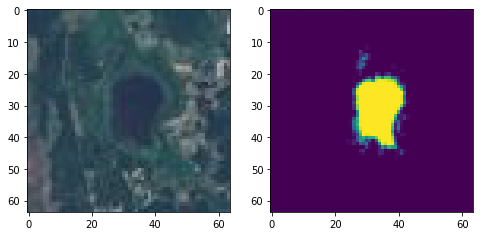

In [18]:
index = clean_data.iloc[0]['indices']
image_path = images_dir + str(index) + '.jpeg'
mask_path = masks_dir + str(index) + '.png'
image = plt.imread(image_path)
mask = plt.imread(mask_path)
print(image.shape)
print(mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(8,8)) 
ax[0].imshow(image)
ax[1].imshow(mask);

# Create PyTorch DataLoader

In [19]:
class CFDDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        index_ = self.dataset.iloc[index]['indices']

        # Get image and mask file paths for specified index
        image_path = images_dir + str(index_) + '.jpeg'
        mask_path = masks_dir + str(index_) + '.png'
        
        # Read image
        image = plt.imread(image_path)
        image = image.transpose((2, 1, 0))
        
        # Read image
        mask = plt.imread(mask_path)
        # print(mask.shape, type(mask), image.shape, type(image))
        mask = mask.transpose((1, 0))[None, :]
        
        # Convert to Pytorch tensor
        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))
        
        return image_tensor, mask_tensor
    
    def __len__(self):
        return len(self.dataset)

In [20]:
def get_dataloaders(data, batch_size):
    datasets = {
        'train' : CFDDataset(data[data.split == 'train']),
        'test' : CFDDataset(data[data.split == 'test'])
    }

    dataloaders = {
        'train': DataLoader(
          datasets['train'],
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers
        ),
        'test': DataLoader(
          datasets['test'],
          batch_size=batch_size,
          drop_last=False,
          num_workers=num_workers
        )
    }
    return dataloaders

## Visualize crop field training set

In [21]:
def visualize_batch(batch, batch_size):
    fig, ax = plt.subplots(2, 4, figsize=(batch_size*3, batch_size*1.5))

    for i in range(batch_size):
        image = batch[0][i].cpu().numpy()
        mask = batch[1][i].cpu().numpy()

        image = image.transpose((1, 2, 0))
        mask = mask.transpose((1, 2, 0)).squeeze()

        image = (image * 255.0).astype("uint8")
        mask = (mask * 255.0).astype("uint8")

        ax[0, i].imshow(image)
        ax[1, i].imshow(mask)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Let's visualize a batch of 4 images as follows.

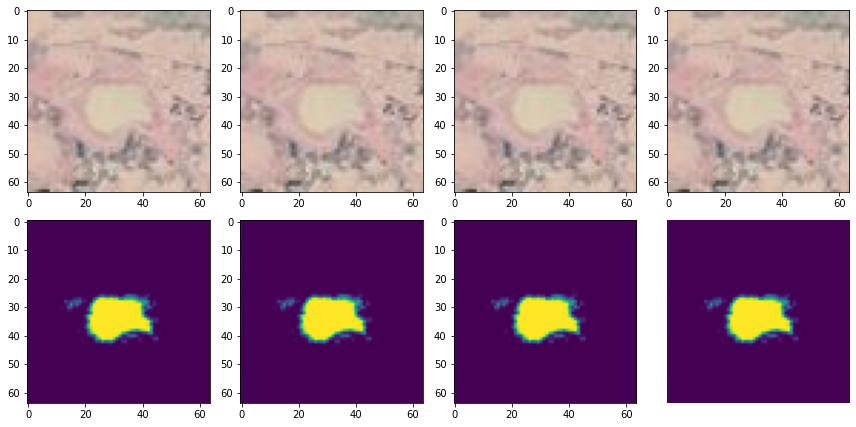

In [22]:
batch_size = 4
num_workers = 0
dataloaders = get_dataloaders(clean_data, batch_size=batch_size)
train_batch = next(iter(dataloaders['train']))
visualize_batch(train_batch, batch_size)

In [23]:
print(train_batch[1][1].cpu().numpy().shape)

(1, 64, 64)


In [24]:
# train_batch = next(iter(dataloaders['train']))
# image = train_batch.next()[0][i].cpu().numpy()
# print(image)

# Model development

## U-Net architecture

In [25]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super().__init__()

        self.encoder1 = self.block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.block(features, features*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.block(features*2, features*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.block(features*4, features*8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.block(features*8, features*16)

        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = self.block(features*16, features*8)
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = self.block(features*8, features*4)
        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = self.block(features*4, features*2)
        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self.block(features*2, features)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))

        return torch.sigmoid(self.conv(dec1))

    def block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
      )

## Instantiate model

In [26]:
model = Unet()
print(model)
input, target = next(iter(dataloaders['train']))
pred = model(input)
pred.shape

Unet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv2d(6

torch.Size([4, 1, 64, 64])

## Loss function

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, lambda_=1.):
        super(DiceLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, y_pred, y_true):
        y_pred = y_pred[:, 0].view(-1)
        y_true = y_true[:, 0].view(-1)
        intersection = (y_pred * y_true).sum()
        dice_loss = (2. * intersection  + self.lambda_) / (
            y_pred.sum() + y_true.sum() + self.lambda_
        )
        return 1. - dice_loss

## Model traning

In [28]:
def train(model, dataloader, criterion, optimizer):
    model.train(True)  

    for input, target in tqdm(dataloader, total=len(dataloader)):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            output = model(input)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

    return loss

## Evaluation function

In [29]:
def evaluate(model, dataloader, criterion):
    model.eval()
    for input, target in tqdm(dataloader, total=len(dataloader)):
        input = input.to(device)
        target = target.to(device)

        with torch.set_grad_enabled(False):
            output = model(input)
            loss = criterion(output, target)
      
    return loss

## Hyperparameters

In [30]:
n_epochs = 15
learning_rate = 0.0001
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
def plot_model_images():
    i = 2
    model.eval()
    index = clean_data[clean_data.split == 'test' ].iloc[i]['indices']
    image_path = images_dir + str(index) + '.jpeg'
    image = plt.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    plt.show()
    
    image = image.transpose((2, 1, 0))[None, :]
    image = torch.from_numpy(image.astype(np.float32)).to(device)
    pred = model(image).cpu().detach().numpy()
    pred = pred.squeeze().transpose((1, 0))
    pred = (pred * 255.0).astype("uint8")
    plt.imshow(pred)
    plt.show()

## Train and evaluate model


Epoch 1/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.6001171469688416, Val loss: 0.6034870147705078
(64, 64, 3)


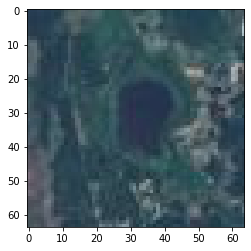

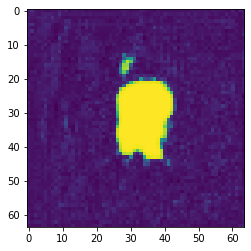


Epoch 2/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.45538330078125, Val loss: 0.4580305814743042
(64, 64, 3)


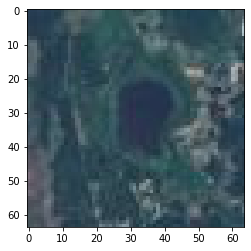

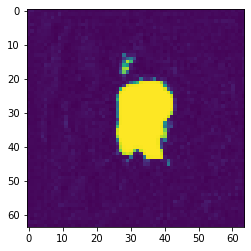


Epoch 3/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.31481409072875977, Val loss: 0.3163720369338989
(64, 64, 3)


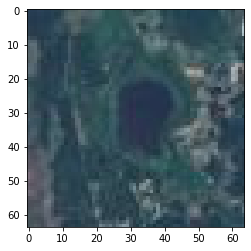

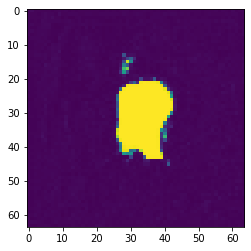


Epoch 4/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.21950632333755493, Val loss: 0.2205389142036438
(64, 64, 3)


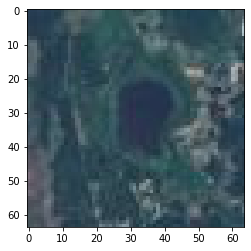

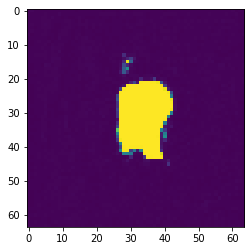


Epoch 5/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.1652524471282959, Val loss: 0.16566503047943115
(64, 64, 3)


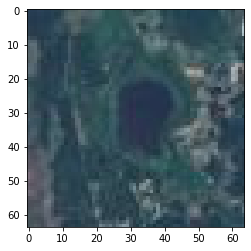

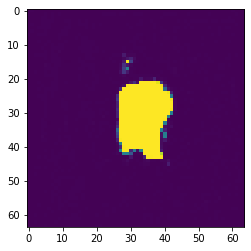


Epoch 6/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.13429546356201172, Val loss: 0.13456225395202637
(64, 64, 3)


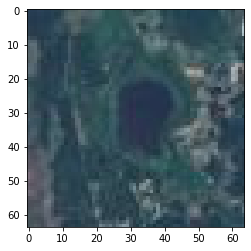

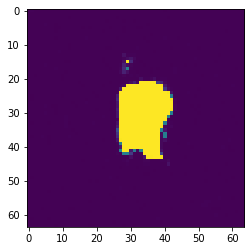


Epoch 7/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.11618632078170776, Val loss: 0.11636114120483398
(64, 64, 3)


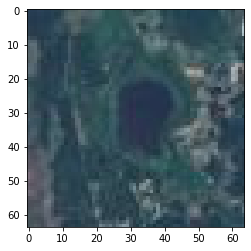

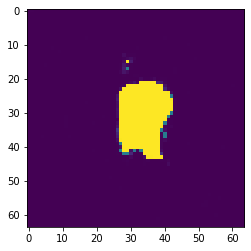


Epoch 8/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.104580819606781, Val loss: 0.10475581884384155
(64, 64, 3)


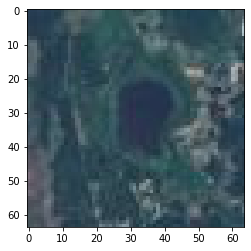

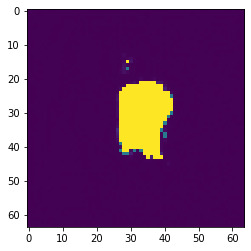


Epoch 9/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.09669214487075806, Val loss: 0.09680259227752686
(64, 64, 3)


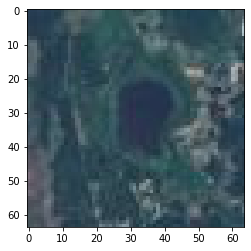

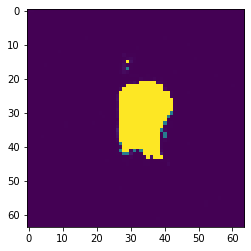


Epoch 10/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.08747774362564087, Val loss: 0.08758032321929932
(64, 64, 3)


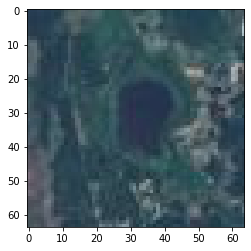

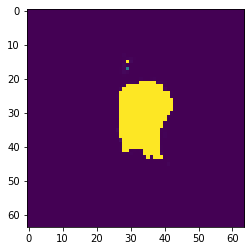


Epoch 11/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.08401334285736084, Val loss: 0.08405297994613647
(64, 64, 3)


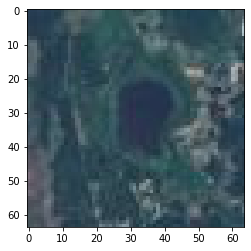

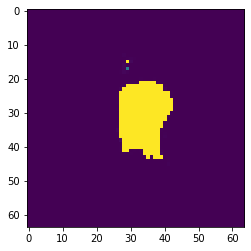


Epoch 12/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.08155274391174316, Val loss: 0.08157241344451904
(64, 64, 3)


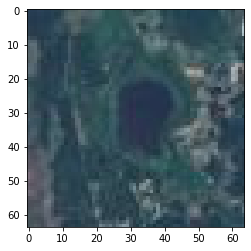

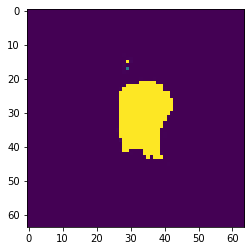


Epoch 13/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.07975292205810547, Val loss: 0.07978081703186035
(64, 64, 3)


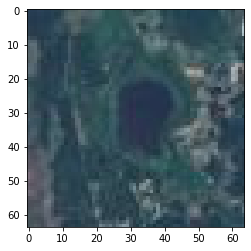

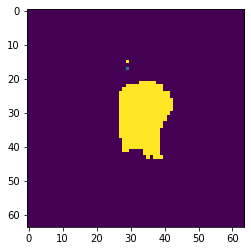


Epoch 14/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.0772210955619812, Val loss: 0.07727479934692383
(64, 64, 3)


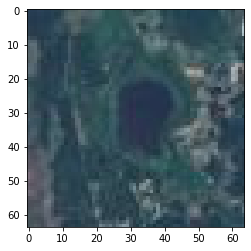

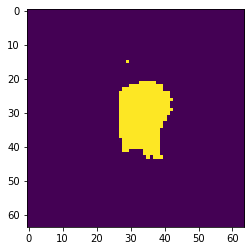


Epoch 15/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.07621455192565918, Val loss: 0.07624107599258423
(64, 64, 3)


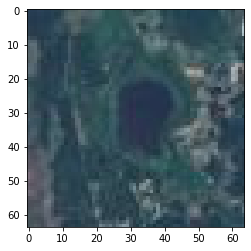

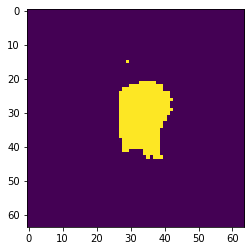

In [32]:
model.to(device)
for epoch in range(1, n_epochs + 1):    
    print("\nEpoch {}/{}".format(epoch, n_epochs))
    print("-" * 10)

    train_loss = train(
        model,
        dataloaders["train"],
        criterion,
        optimizer
    )
    val_loss = evaluate(
        model,
        dataloaders['test'],
        criterion
    )
    print('Train loss: {}, Val loss: {}'.format(
        train_loss.cpu().detach().numpy(), 
        val_loss.cpu().detach().numpy())
    )
    plot_model_images()

## Save model

In [ ]:
model_dir = cwd+"models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_file = model_dir + 'best_model_test_single.pth'
torch.save(model.state_dict(), model_file)
print('Model successfully saved to {}'.format(model_file))

## Load model

In [ ]:
# model_dir = "./drive/My Drive/Colab Notebooks/Crop Field Delineation/models/"
model_file = model_dir + 'best_model_test_single.pth'

loaded_model = Unet()
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

# Evaluate on a Single Image

In [ ]:
i = 2
model.eval()
index = clean_data[clean_data.split == 'test' ].iloc[i]['indices']
image_path = images_dir + str(index) + '.jpeg'
image = plt.imread(image_path)
print(image.shape)
plt.imshow(image)

In [ ]:
image = image.transpose((2, 1, 0))[None, :]
image = torch.from_numpy(image.astype(np.float32)).to(device)
pred = model(image).cpu().detach().numpy()
pred = pred.squeeze().transpose((1, 0))
pred = (pred * 255.0).astype("uint8")
plt.imshow(pred)

In [ ]:
end = time.time()
total_time = end - start
print("%s: Total time = %f seconds" % (time.strftime("%Y/%m/%d-%H:%M:%S"), total_time))